In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLEANING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

file = "/Users/patrickfahy99/Documents/Kaggle_datasets/training.1600000.processed.noemoticon.csv"
df = pd.read_csv(file, encoding = DATASET_ENCODING , names= DATASET_COLUMNS)
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [4]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [5]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 456 ms, sys: 12.4 ms, total: 469 ms
Wall time: 496 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

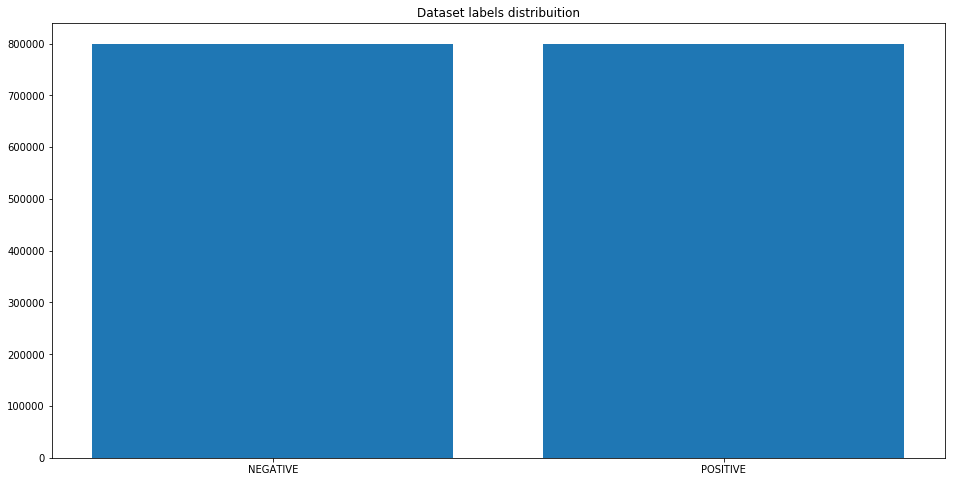

In [6]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [7]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [8]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [9]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 52.5 s, sys: 710 ms, total: 53.2 s
Wall time: 58.5 s


In [10]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [11]:
%%time
documents = [_text.split() for _text in df_train.text]

CPU times: user 2.48 s, sys: 247 ms, total: 2.73 s
Wall time: 2.77 s


In [12]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [13]:
w2v_model.build_vocab(documents)

2020-08-14 17:15:35,000 : INFO : collecting all words and their counts
2020-08-14 17:15:35,002 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-08-14 17:15:35,023 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-08-14 17:15:35,044 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-08-14 17:15:35,062 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-08-14 17:15:35,088 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-08-14 17:15:35,107 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-08-14 17:15:35,124 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-08-14 17:15:35,150 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-08-14 17:15:35,167 : INFO : PROGRESS: at s

2020-08-14 17:15:36,437 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2020-08-14 17:15:36,456 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2020-08-14 17:15:36,473 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2020-08-14 17:15:36,491 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2020-08-14 17:15:36,510 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2020-08-14 17:15:36,528 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2020-08-14 17:15:36,546 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2020-08-14 17:15:36,564 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2020-08-14 17:15:36,581 : INFO : PROGRESS: at sentence #800000, processed 577088

In [14]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [15]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-08-14 17:18:33,524 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-08-14 17:18:34,609 : INFO : EPOCH 1 - PROGRESS: at 5.97% examples, 462798 words/s, in_qsize 16, out_qsize 0
2020-08-14 17:18:35,616 : INFO : EPOCH 1 - PROGRESS: at 13.90% examples, 551815 words/s, in_qsize 16, out_qsize 1
2020-08-14 17:18:36,640 : INFO : EPOCH 1 - PROGRESS: at 22.54% examples, 599183 words/s, in_qsize 15, out_qsize 0
2020-08-14 17:18:37,656 : INFO : EPOCH 1 - PROGRESS: at 31.64% examples, 632983 words/s, in_qsize 16, out_qsize 1
2020-08-14 17:18:38,659 : INFO : EPOCH 1 - PROGRESS: at 40.94% examples, 658451 words/s, in_qsize 16, out_qsize 0
2020-08-14 17:18:39,677 : INFO : EPOCH 1 - PROGRESS: at 50.14% examples, 672474 words/s, in_qsize 16, out_qsize 0
2020-08-14 17:18:40,695 : INFO : EPOCH 1 - PROGRESS: at 56.73% examples, 652766 words/s, in_qsize 12, out_qsize 3
2020-08-14 17:18:41,708 : INFO : EPOCH 1 - PROGRESS: 

2020-08-14 17:19:18,904 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-14 17:19:18,905 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-14 17:19:18,905 : INFO : EPOCH - 4 : training on 9227204 raw words (8223705 effective words) took 10.7s, 771279 effective words/s
2020-08-14 17:19:19,932 : INFO : EPOCH 5 - PROGRESS: at 8.80% examples, 718225 words/s, in_qsize 16, out_qsize 0
2020-08-14 17:19:20,947 : INFO : EPOCH 5 - PROGRESS: at 16.38% examples, 665900 words/s, in_qsize 16, out_qsize 0
2020-08-14 17:19:21,959 : INFO : EPOCH 5 - PROGRESS: at 23.42% examples, 634680 words/s, in_qsize 16, out_qsize 0
2020-08-14 17:19:22,966 : INFO : EPOCH 5 - PROGRESS: at 30.35% examples, 617791 words/s, in_qsize 14, out_qsize 1
2020-08-14 17:19:23,983 : INFO : EPOCH 5 - PROGRESS: at 36.72% examples, 597394 words/s, in_qsize 13, out_qsize 2
2020-08-14 17:19:24,991 : INFO : EPOCH 5 - PROGRESS: at 45.38% examples, 615541 words/s, in_qsize 16, out_qsize

2020-08-14 17:20:08,985 : INFO : EPOCH 8 - PROGRESS: at 88.59% examples, 550766 words/s, in_qsize 15, out_qsize 0
2020-08-14 17:20:10,013 : INFO : EPOCH 8 - PROGRESS: at 97.93% examples, 564713 words/s, in_qsize 16, out_qsize 0
2020-08-14 17:20:10,124 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-08-14 17:20:10,137 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-08-14 17:20:10,157 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-08-14 17:20:10,163 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-08-14 17:20:10,172 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-14 17:20:10,175 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-14 17:20:10,188 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-14 17:20:10,193 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-14 17:20:10,194 : INFO : EPOCH - 8 :

2020-08-14 17:20:53,695 : INFO : EPOCH 12 - PROGRESS: at 16.70% examples, 683010 words/s, in_qsize 15, out_qsize 0
2020-08-14 17:20:54,724 : INFO : EPOCH 12 - PROGRESS: at 25.48% examples, 689329 words/s, in_qsize 15, out_qsize 0
2020-08-14 17:20:55,729 : INFO : EPOCH 12 - PROGRESS: at 34.46% examples, 700808 words/s, in_qsize 16, out_qsize 0
2020-08-14 17:20:56,732 : INFO : EPOCH 12 - PROGRESS: at 42.13% examples, 686883 words/s, in_qsize 15, out_qsize 0
2020-08-14 17:20:57,750 : INFO : EPOCH 12 - PROGRESS: at 50.56% examples, 686147 words/s, in_qsize 16, out_qsize 1
2020-08-14 17:20:58,756 : INFO : EPOCH 12 - PROGRESS: at 60.09% examples, 699390 words/s, in_qsize 15, out_qsize 0
2020-08-14 17:20:59,771 : INFO : EPOCH 12 - PROGRESS: at 68.43% examples, 696421 words/s, in_qsize 15, out_qsize 1
2020-08-14 17:21:00,840 : INFO : EPOCH 12 - PROGRESS: at 76.77% examples, 689908 words/s, in_qsize 15, out_qsize 0
2020-08-14 17:21:01,871 : INFO : EPOCH 12 - PROGRESS: at 83.72% examples, 676135

2020-08-14 17:21:39,637 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-14 17:21:39,638 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-14 17:21:39,639 : INFO : EPOCH - 15 : training on 9227204 raw words (8222960 effective words) took 10.2s, 808097 effective words/s
2020-08-14 17:21:40,664 : INFO : EPOCH 16 - PROGRESS: at 10.42% examples, 845563 words/s, in_qsize 15, out_qsize 0
2020-08-14 17:21:41,665 : INFO : EPOCH 16 - PROGRESS: at 21.03% examples, 858451 words/s, in_qsize 15, out_qsize 1
2020-08-14 17:21:42,667 : INFO : EPOCH 16 - PROGRESS: at 31.65% examples, 862817 words/s, in_qsize 15, out_qsize 0
2020-08-14 17:21:43,688 : INFO : EPOCH 16 - PROGRESS: at 40.83% examples, 832063 words/s, in_qsize 15, out_qsize 0
2020-08-14 17:21:44,688 : INFO : EPOCH 16 - PROGRESS: at 48.19% examples, 787050 words/s, in_qsize 12, out_qsize 2
2020-08-14 17:21:45,698 : INFO : EPOCH 16 - PROGRESS: at 55.75% examples, 758744 words/s, in_qsize 14, o

2020-08-14 17:22:29,605 : INFO : EPOCH 19 - PROGRESS: at 71.13% examples, 519918 words/s, in_qsize 14, out_qsize 1
2020-08-14 17:22:30,664 : INFO : EPOCH 19 - PROGRESS: at 79.92% examples, 533764 words/s, in_qsize 15, out_qsize 0
2020-08-14 17:22:31,664 : INFO : EPOCH 19 - PROGRESS: at 90.54% examples, 559203 words/s, in_qsize 16, out_qsize 0
2020-08-14 17:22:32,691 : INFO : EPOCH 19 - PROGRESS: at 97.72% examples, 560100 words/s, in_qsize 14, out_qsize 7
2020-08-14 17:22:32,835 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-08-14 17:22:32,854 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-08-14 17:22:32,855 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-08-14 17:22:32,872 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-08-14 17:22:32,885 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-14 17:22:32,903 : INFO : worker thread finished; awaiting finish of 2 more th

2020-08-14 17:23:13,780 : INFO : EPOCH 23 - PROGRESS: at 7.49% examples, 588230 words/s, in_qsize 16, out_qsize 0
2020-08-14 17:23:14,801 : INFO : EPOCH 23 - PROGRESS: at 15.08% examples, 599466 words/s, in_qsize 15, out_qsize 1
2020-08-14 17:23:15,816 : INFO : EPOCH 23 - PROGRESS: at 22.76% examples, 607205 words/s, in_qsize 16, out_qsize 0
2020-08-14 17:23:16,847 : INFO : EPOCH 23 - PROGRESS: at 31.31% examples, 626141 words/s, in_qsize 14, out_qsize 4
2020-08-14 17:23:17,858 : INFO : EPOCH 23 - PROGRESS: at 40.62% examples, 652077 words/s, in_qsize 15, out_qsize 1
2020-08-14 17:23:18,860 : INFO : EPOCH 23 - PROGRESS: at 49.92% examples, 670515 words/s, in_qsize 16, out_qsize 0
2020-08-14 17:23:19,870 : INFO : EPOCH 23 - PROGRESS: at 58.79% examples, 678097 words/s, in_qsize 16, out_qsize 0
2020-08-14 17:23:20,888 : INFO : EPOCH 23 - PROGRESS: at 67.02% examples, 676390 words/s, in_qsize 16, out_qsize 0
2020-08-14 17:23:21,896 : INFO : EPOCH 23 - PROGRESS: at 74.69% examples, 671066 

2020-08-14 17:24:05,872 : INFO : EPOCH 26 - PROGRESS: at 66.15% examples, 484416 words/s, in_qsize 16, out_qsize 1
2020-08-14 17:24:06,872 : INFO : EPOCH 26 - PROGRESS: at 72.65% examples, 488496 words/s, in_qsize 15, out_qsize 0
2020-08-14 17:24:07,909 : INFO : EPOCH 26 - PROGRESS: at 79.38% examples, 491895 words/s, in_qsize 15, out_qsize 1
2020-08-14 17:24:08,921 : INFO : EPOCH 26 - PROGRESS: at 85.99% examples, 495106 words/s, in_qsize 16, out_qsize 0
2020-08-14 17:24:09,936 : INFO : EPOCH 26 - PROGRESS: at 92.39% examples, 496580 words/s, in_qsize 13, out_qsize 2
2020-08-14 17:24:10,956 : INFO : EPOCH 26 - PROGRESS: at 98.79% examples, 497717 words/s, in_qsize 11, out_qsize 1
2020-08-14 17:24:11,009 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-08-14 17:24:11,027 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-08-14 17:24:11,031 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-08-14 17:24:11,042 : INFO : work

2020-08-14 17:24:57,605 : INFO : EPOCH 29 - PROGRESS: at 96.64% examples, 555883 words/s, in_qsize 15, out_qsize 6
2020-08-14 17:24:57,815 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-08-14 17:24:57,832 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-08-14 17:24:57,844 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-08-14 17:24:57,846 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-08-14 17:24:57,852 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-14 17:24:57,861 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-14 17:24:57,866 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-14 17:24:57,870 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-14 17:24:57,871 : INFO : EPOCH - 29 : training on 9227204 raw words (8222771 effective words) took 14.6s, 564735 effective words/s
2020-08-14 17:24:5

2020-08-14 17:25:45,907 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-14 17:25:45,908 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-14 17:25:45,920 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-14 17:25:45,925 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-14 17:25:45,926 : INFO : EPOCH - 32 : training on 9227204 raw words (8222713 effective words) took 15.2s, 541740 effective words/s
2020-08-14 17:25:45,927 : INFO : training on a 295270528 raw words (263126911 effective words) took 432.4s, 608505 effective words/s


CPU times: user 17min 42s, sys: 10.8 s, total: 17min 53s
Wall time: 7min 12s


(263126911, 295270528)

In [16]:
w2v_model.most_similar("love")

/Users/patrickfahy99/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-08-14 17:25:45,954 : INFO : precomputing L2-norms of word weight vectors


[('loves', 0.5708763599395752),
 ('luv', 0.5615824460983276),
 ('loved', 0.5379835367202759),
 ('amazing', 0.5128701329231262),
 ('adore', 0.5055758953094482),
 ('looove', 0.49470338225364685),
 ('loveee', 0.4644308090209961),
 ('awesome', 0.4535677134990692),
 ('loooove', 0.4430655241012573),
 ('lovee', 0.43686267733573914)]

In [17]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 20.8 s, sys: 426 ms, total: 21.2 s
Wall time: 21.8 s


In [18]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 30.1 s, sys: 1.59 s, total: 31.7 s
Wall time: 34.4 s


In [19]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [20]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [21]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [22]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [23]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [24]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], 
                            input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at} 

In [ ]:
predict("I love the music")

In [ ]:
predict("I hate the rain")

In [ ]:
predict("i don't know what i'm doing")

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)